# **Uso della VQE per determinare la presenza di una transizione di fase**

Nel programma di seguito realizzato verrà verificata la presenza di una transizione di fase mediante lo studio dell'energia dei primi livelli eccitati.


In [ ]:
!pip install pennylane
!pip install qiskit
!pip install torch

In [ ]:
#importazione delle librerie utili
import qiskit
import torch
import torch.nn as nn
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector

PennyLane version: 0.40.0


Parte di codice utile alla preparazione degli stati iniziali: singoletto e tripletto.

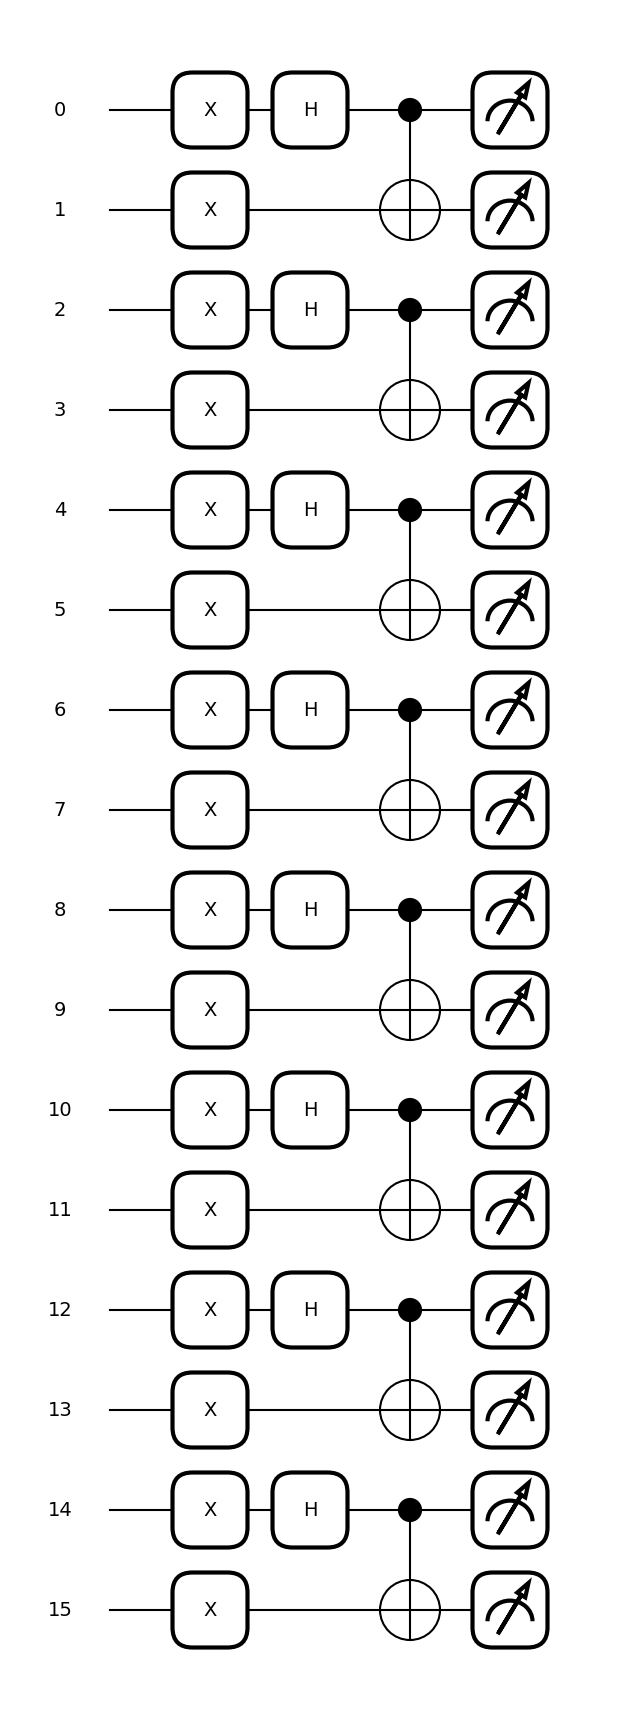

In [ ]:
#creazione dello stato parte 1

# Preparazione dello stato iniziale di singoletto phi_0
"""
16 qubit iniziali, a ciascuno si applica Pauli X, poi Hadamard a quelli pari e poi il CNOT: il tutto compone la matrice U_s (Fig.4a)
"""

dev = qml.device('default.qubit', wires=16)
@qml.qnode(dev)
def circuit_S():
  for i in range(0, 15, 2):
    qml.PauliX(wires=i)
    qml.PauliX(wires=i+1)
    qml.Hadamard(wires=i)
    qml.CNOT(wires=[i,i+1])
  return qml.state()

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit_S)()
plt.show()
Statevector(circuit_S()).draw('latex')

singoletto=circuit_S()

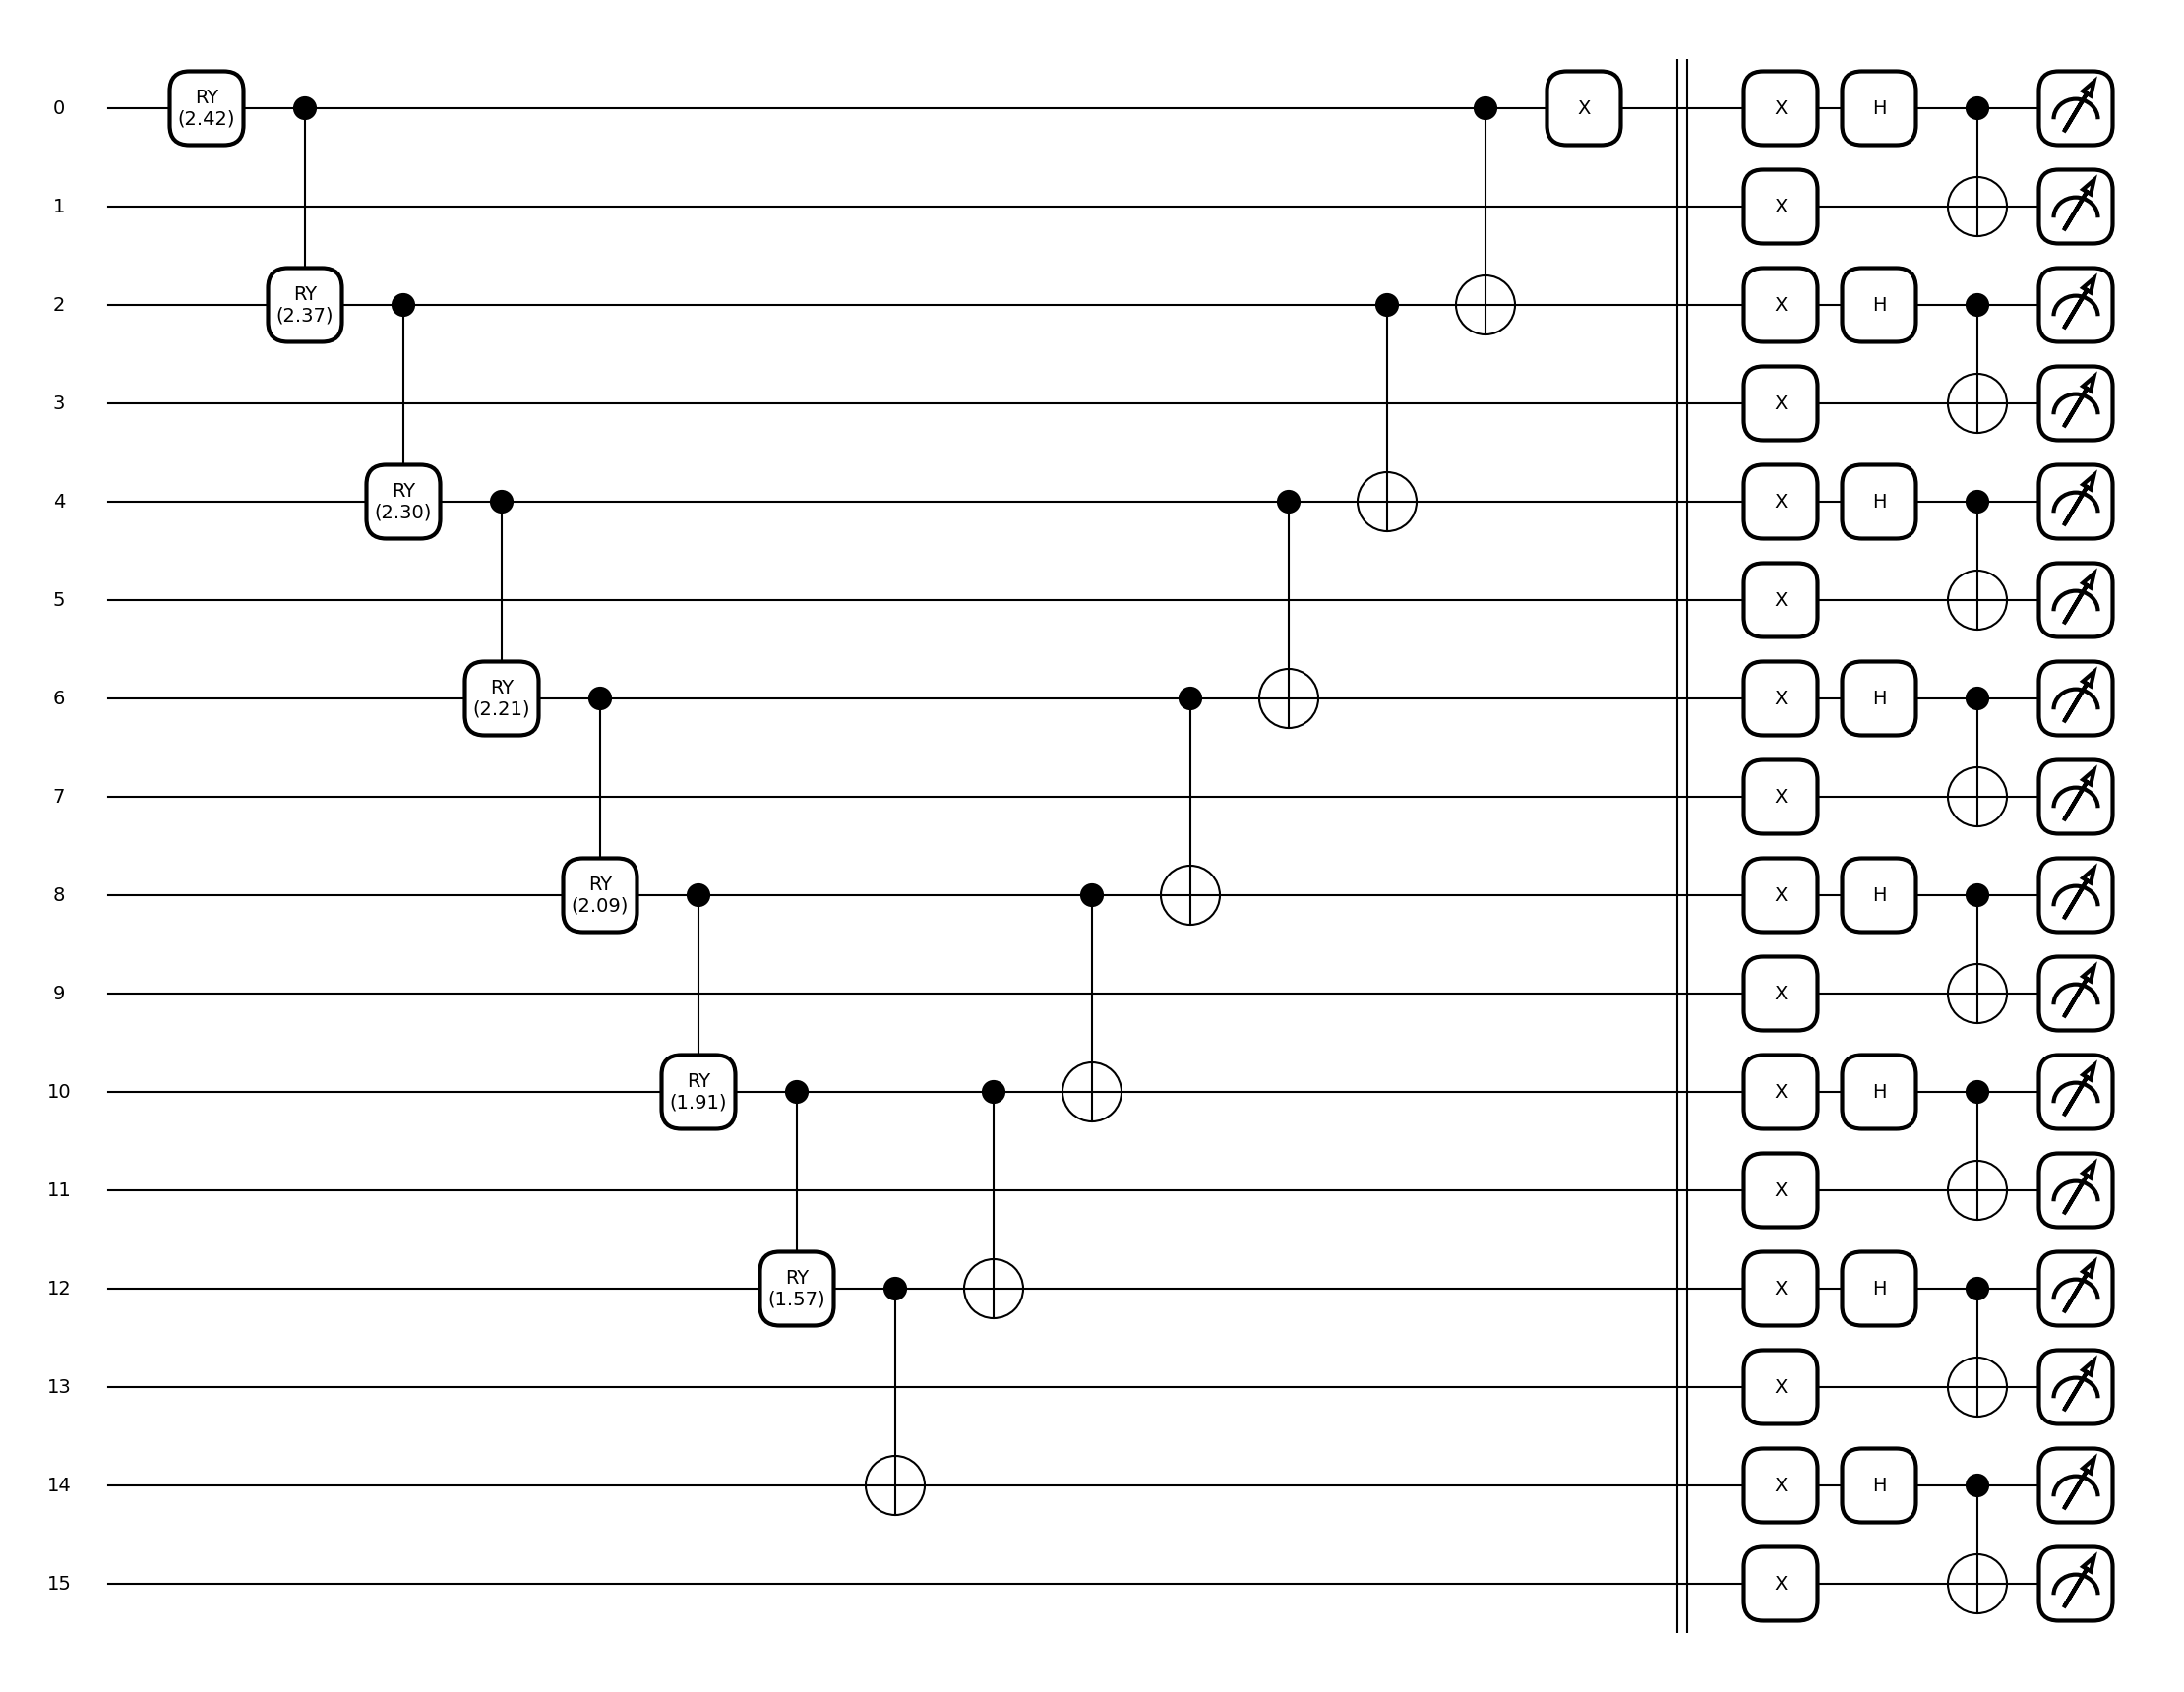

In [ ]:
#creazione dello stato parte 2

# Preparazione dello stato iniziale di tripletto phi_1
"""
Ai qubit pari di indice 0<=i<=12 (poiché si conta a partire da 0) si applica una rotazione attorno a Y di angolo phi_i=2arccos[1/sqrt(17-i)]
Per i>=2 la rotazione è controllata dal qubit pari precedente
Poi si applica un CNOT per 0<=i<=14 (a partire da i=14) a ogni qubit pari: ognuno è controllato dal precedente qubit pari
A i=0 si applica Pauli X
A tutto si applica U_s di cui sopra (Fig.4b dell'articolo)
"""

dev = qml.device('default.qubit', wires=16)
@qml.qnode(dev)
def circuit_T():
  qml.RY(2*np.arccos(1/np.sqrt(8-1+1)), wires=0)
  for i in range(2, 13, 2):
    qml.CRY(2*np.arccos(1/np.sqrt(8-i/2-1+1)), wires=[i-2,i])
  for i in range(2, 15, 2):
    qml.CNOT(wires=[15-1-i,15-i+1])
  qml.PauliX(wires=0)
  qml.Barrier(wires=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], only_visual=True)
  for i in range(0, 15, 2):
    qml.PauliX(wires=i)
    qml.PauliX(wires=i+1)
    qml.Hadamard(wires=i)
    qml.CNOT(wires=[i,i+1])

  return qml.state()

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit_T, decimals=2)()
plt.show()
Statevector(circuit_T()).draw('latex')

tripletto=circuit_T()

La parte di seguito definisce i singoli pezzi del circuito che verranno poi 'assemblati ' e fatti agire successivamente sugli stati inizialmente preparati.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


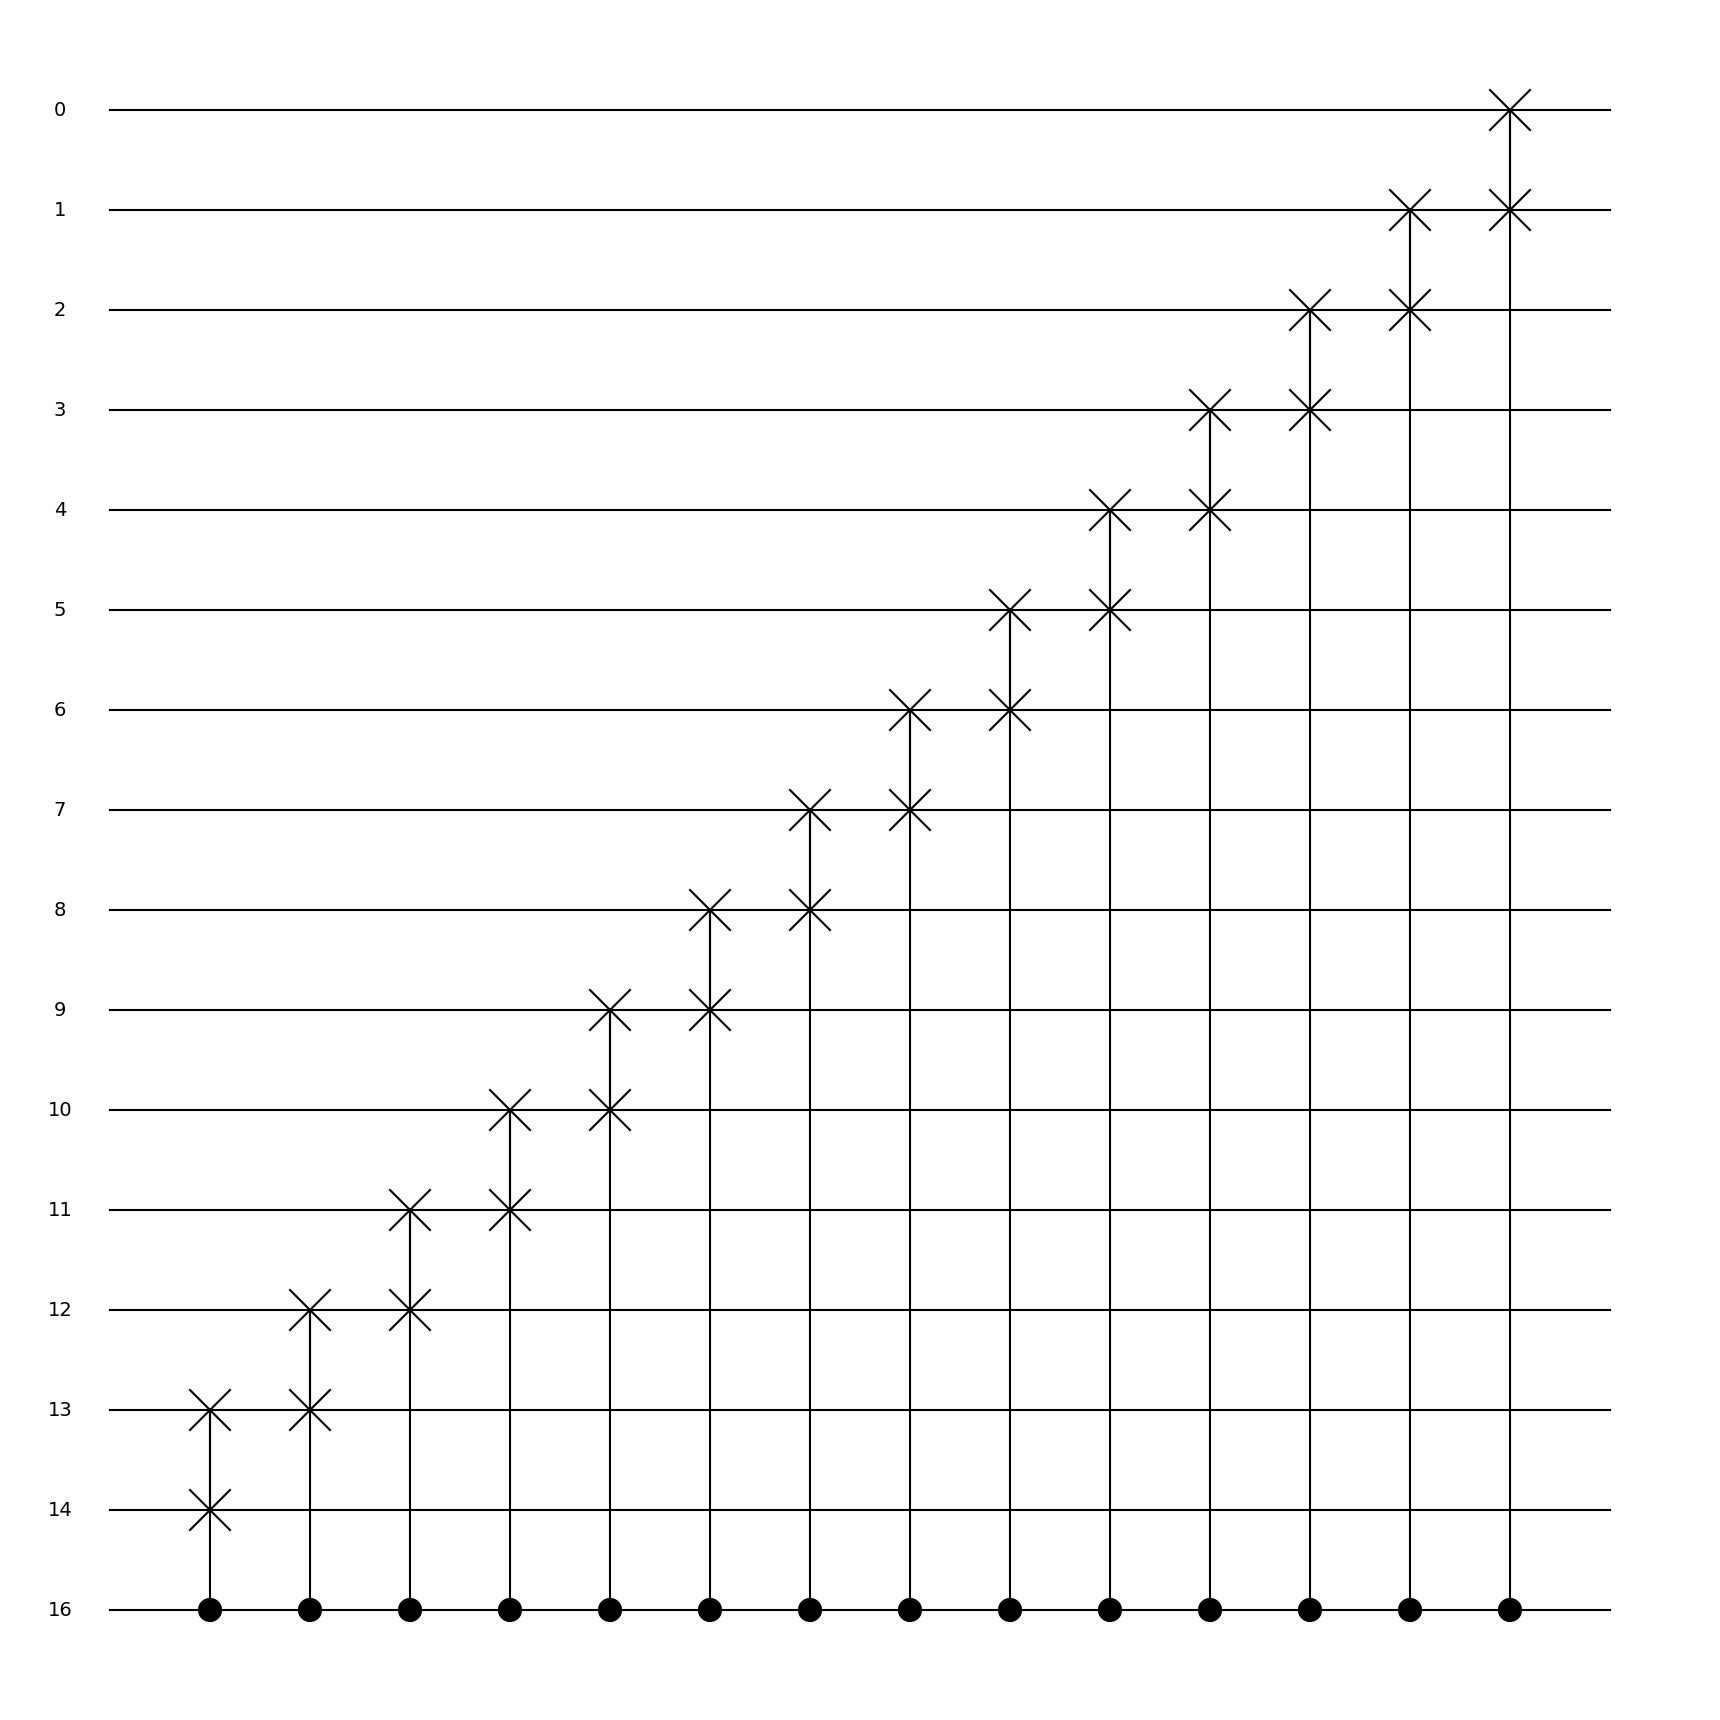

In [ ]:
#CREAZIONE DEI PEZZI PER IL CIRCUITO

#Il circuito si basa sull'applicazione e ripetizione di alcuni elementi fondanti che sono XX, YY, ZZ.
#A sua volta questi elementi sono di fatto dei piccoli circuiti, per cui in prima battuta implementerò loro
#XX e YY sfruttano le matrici di cambio base da x, y a z, per cui procederò definendo prima quelle esplicitamente

#Matrice di cambio di base da x a z (NOTO CHE QUESTA E' UGUALE ALLA SUA DAGA)
UX= np.array([[0.70710678+0j, 0.70710678+0j],
              [0.70710678+0j, -0.70710678+0j]])

#Matrice di cambio di base da y a z
UY= np.array([[0.70710678+0j, 0.70710678+0j],
              [0.70710678*(1j), -(0.70710678)*(1j)]])

UYdaga=np.conj(UY).T

#Matrice di cambio di base da z a z (NOTO CHE QUESTA E' L'IDENTITA')
UZ= np.array([[1, 0],
              [0, 1]])

#print(U_x, U_y, U_y_daga, U_z)


#Definite ora le unità base di XX, YY, ZZ, voglio implementare XX, YY, ZZ


def XX(params, wires):  #ising x?
    """
    Circuito XX che opera su due qubit.

    Args:
        params: Lista contenente il parametro tetha per la rotazione attorno a Z.
        wires: I due qubit su cui operare.

    """

    qml.QubitUnitary(UX, wires=wires[0])
    qml.QubitUnitary(UX, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.QubitUnitary(UX, wires=wires[0])
    qml.QubitUnitary(UX, wires=wires[1])



def YY(params, wires):
    """
    Circuito YY che opera su due qubit.

    Args:
        params: Lista contenente il parametro tetha per la rotazione attorno a Z.
        wires: I due qubit su cui operare.

    """

    qml.QubitUnitary(UY, wires=wires[0])
    qml.QubitUnitary(UY, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.QubitUnitary(UYdaga, wires=wires[0])
    qml.QubitUnitary(UYdaga, wires=wires[1])


def ZZ(params, wires):
    """
    Circuito ZZ che opera su due qubit.

    Args:
        params: Lista contenente il parametro tetha per la rotazione attorno a Z.
        wires: I due qubit su cui operare.

    """

    qml.QubitUnitary(UZ, wires=wires[0])
    qml.QubitUnitary(UZ, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.QubitUnitary(UZ, wires=wires[0])
    qml.QubitUnitary(UZ, wires=wires[1])



#L'algoritmo poi si compone di due ulteriori blocchi principali che sono exp(i theta1 H1) e exp(i theta2 H2)
#costruiremo quindi di seguito questi due blocchi che agiscano su un numero di qubit arbitrario

#PRIMO BLOCCO



def exp1(params, wires):
    """
    Circuito che applica la matrice XX, YY, ZZ a coppie di qubit consecutive e ai qubit estremi.

    Args:
        params: Lista di parametri (non utilizzati in questo caso).
        wires: Qubit wires.
    """

    # Applica XX, YY, ZZ a coppie consecutive di qubit
    for i in range(1, len(wires) - 1,2 ):
        XX(params,wires[i:i+2])
        YY(params,wires[i:i+2])
        ZZ(params,wires[i:i+2])


    # Applica XX al primo e ultimo qubit
    XX(params, [wires[-1], wires[0]])
    YY(params, [wires[-1], wires[0]])
    ZZ(params, [wires[-1], wires[0]])

#con lo stesso principio definisco ora il SECONDO BLOCCO



def exp2(params, wires):
    """
    Circuito che applica la matrice XX, YY, ZZ a coppie di qubit consecutive e ai qubit estremi.

    Args:
        params: Lista di parametri (non utilizzati in questo caso).
        wires: Qubit wires.
    """

    # Applica XX, YY, ZZ a coppie consecutive di qubit
    for i in range(0, len(wires)-1, 2):
        XX(params,wires[i:i+2])
        YY(params,wires[i:i+2])
        ZZ(params,wires[i:i+2])





#I blocchi finora menzionati verrano ripetuti in maniera oridinata un certo numero di volte pari al numero di
#layer scelto per il problema (legato al numero di parametri che si intendono minimizzare)
#affinchè siano valide le ipotesi teoriche utili a trovare l'energia dei primi stati eccitati tramite minimizzazione
#lo stato deve soddisfare proprietà di simmetria rispetto a S^2 e T (traslazione di un sito)

#per restaurare l'invarianza rispetto alla traslazione di un sito, dopo l'applicazione dell'operatore unitario
#verrà introdotta un'ancella e un operazione di control T con T operatore unitario di traslazione di un sito


def T(wires):
    """
    Implementa un'operazione di shift controllata specifica su un registro di N qubit.

    Args:
        wires (list): Lista degli N+1 wire coinvolti nell'operazione. L'ultimo wire è l'ancilla.
    """
    N=len(wires)

    for i in range (1,N,1):

        qml.SWAP(wires=[wires[N-i], wires[N-1-i]])


def CT(control_wire, target_wires):
    """
    Implementa un operatore controllato che applica la trasformazione T agli N qubit
    specificati da `target_wires` se il qubit di controllo `control_wire` è in stato |1>.

    Args:
        control_wire (int): The control qubit.
        target_wires (list): Lista di qubit su cui applicare T.
    """
    # Define the controlled-T operation using qml.ctrl
    T_op = qml.ctrl(T, control=control_wire)
    # Apply the controlled-T operation
    T_op(target_wires)

wires= [0,1,2,3, 4 ,5, 6, 7, 8, 9 ,10, 11, 12, 13, 14 ,15]
wires_ancilla=wires + [16]

print(wires_ancilla)

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(CT, expansion_strategy="device")(16, wires[0:16])
plt.show()



Implementazione del circuito che poi verrà applicato agli stati iniziali per il calcolo in definitiva dei valori di aspettazione delle hamiltoniane.

In [ ]:
#inizio ad applicare per un certo numero di layers L fissati l'evolutore e T allo stato di tripletto
#così facendo otterò uno stato che sarà sovrapposizione di csi theta +(k=0) e csi theta - (k=pi).

dev = qml.device('default.qubit', wires=17) # Device con 17 qubit
@qml.qnode(dev)

def circuito_TOTALE(stato_iniziale, theta1, theta2, L):
    """
    Applica gli esponziali exp1 e exp2 tante volte tanti quanti sono i layer L del problema.
    Applicato l' "evolutore" composto come sopra viene inizializzata un ancilla (qubit=17) nello stato |+>.
    Quindi si applica l'operatore CT.

    Args:
        stato_iniziale: Stato iniziale del sistema, valore iniziale dei parametri per il problema, numero di layer L
        theta1: lista di parametri per exp1
        theta2: lista di parametri per exp2

    Returns:
        Stato finale del sistema.
    """
    stato_iniziale=stato_iniziale/np.linalg.norm(stato_iniziale)
    qml.StatePrep(stato_iniziale, wires=range(16))  # Inizializza lo stato iniziale

    for i in range(0,L,1):
        exp1(theta1[i], wires=range(16))
        exp2(theta2[i], wires=range(16))

    qml.Hadamard(wires=16)  # Applica Hadamard all'ancilla per ottenere |+>

    CT(16, range(16))  # Applica CT

    return qml.state()  # Restituisci lo stato finale


"""
Di seguito verrà introdotta l'hamiltoniana del sistema per diversi valori del rapporto J2/J1.
Si calcolerà poi il valore di aspettazione di ciasuna hamiltoniana rispetto allo stato di singoletto con momento zero e a quello di tripletto con momento k,
e a quello di tripletto con momento k.

"""


#HAMILTONIANA '1'

# Creazione dell'hamiltoniana con J_2/J_1=0.15 con condizioni periodiche

ham15 = qml.PauliX(15)@qml.PauliX(0)+qml.PauliY(15)@qml.PauliY(0)+qml.PauliZ(15)@qml.PauliZ(0) + 0.15*(qml.PauliX(14)@qml.PauliX(0)+qml.PauliY(14)@qml.PauliY(0)+qml.PauliZ(14)@qml.PauliZ(0)) + 0.15*(qml.PauliX(15)@qml.PauliX(1)+qml.PauliY(15)@qml.PauliY(1)+qml.PauliZ(15)@qml.PauliZ(1))
for i in range(0,15,1):
  ham15 = ham15 + qml.PauliX(i)@qml.PauliX(i+1)+qml.PauliY(i)@qml.PauliY(i+1)+qml.PauliZ(i)@qml.PauliZ(i+1)
for i in range(0,14,1):
  ham15 = ham15 + 0.15*(qml.PauliX(i)@qml.PauliX(i+2)+qml.PauliY(i)@qml.PauliY(i+2)+qml.PauliZ(i)@qml.PauliZ(i+2))

#HAMILTONIANA '2'

# Creazione dell'hamiltoniana con J_2/J_1=0.35 con condizioni periodiche
ham35 = qml.PauliX(15)@qml.PauliX(0)+qml.PauliY(15)@qml.PauliY(0)+qml.PauliZ(15)@qml.PauliZ(0) + 0.35*(qml.PauliX(14)@qml.PauliX(0)+qml.PauliY(14)@qml.PauliY(0)+qml.PauliZ(14)@qml.PauliZ(0)) + 0.35*(qml.PauliX(15)@qml.PauliX(1)+qml.PauliY(15)@qml.PauliY(1)+qml.PauliZ(15)@qml.PauliZ(1))
for i in range(0,15,1):
  ham35 = ham35 + qml.PauliX(i)@qml.PauliX(i+1)+qml.PauliY(i)@qml.PauliY(i+1)+qml.PauliZ(i)@qml.PauliZ(i+1)
for i in range(0,14,1):
  ham35 = ham35 + 0.35*(qml.PauliX(i)@qml.PauliX(i+2)+qml.PauliY(i)@qml.PauliY(i+2)+qml.PauliZ(i)@qml.PauliZ(i+2))


"""
Si presentano ora le funzioni per il calcolo delle energie per la 'prima' hamiltoniana.

"""

# FUNZIONE PER ENERGIA DELLO STATO DI SINGOLETTO CON MOMENTO 0
dev = qml.device('default.qubit', wires=17) # Device con 17 qubit
@qml.qnode(dev,diff_method="backprop")
def energia_splus15(stato_iniziale):
    """
    Calcola l'energia dell'stato di singoletto con momento 0.
    Per farlo si è scelto di applicare un hadamard all'ancilla, inizialmente in una sovrapposizione di |+> e |->.
    Dopo l'applicazione dell'Hadamard, la componente |+> verrà mappata in |0>, la componenente |-> verrà mappata in |1>.
    Facendo l'operazione di misura e ponendo su di essa una condizione di 'postselect' è possibile considerare la componente cui si è interessati.

    Args:
        stato_iniziale: Stato iniziale del sistema.

    Returns:
        Energia dell'stato di singoletto con momento 0.
    """

    qml.StatePrep(stato_iniziale, wires=range(17))  # Inizializza lo stato iniziale
    qml.Hadamard(wires=16)
    qml.measure(wires=16, postselect=0)
    #ene=qml.math.expectation_value(ham15)
    A=qml.expval(ham15)
    return A

# FUNZIONE PER ENERGIA DELLO STATO DI TRIPLETTO e SINGOLETTO CON MOMENTO K
dev = qml.device('default.qubit', wires=17) # Device con 17 qubit
@qml.qnode(dev,diff_method="backprop")
def energia_tminus15(stato_iniziale):
    """
    Calcola l'energia dell'stato di tripletto/singoletto con momento k.
    Per farlo si è scelto di applicare un hadamard all'ancilla, inizialmente in una sovrapposizione di |+> e |->.
    Dopo l'applicazione dell'Hadamard, la componente |+> verrà mappata in |0>, la componenente |-> verrà mappata in |1>.
    Facendo l'operazione di misura e ponendo su di essa una condizione di 'postselect' è possibile considerare la componente cui si è interessati.

    Args:
        stato_iniziale: Stato iniziale del sistema.

    Returns:
        Energia dell'stato di tripletto/singoletto con momento K.
    """


    qml.StatePrep(stato_iniziale, wires=range(17))  # Inizializza lo stato iniziale
    qml.Hadamard(wires=16)
    qml.measure(wires=16, postselect=1)
    #ene=qml.math.expectation_value(ham15)
    A=qml.expval(ham15)
    return A


"""
Si presentano ora le funzioni per il calcolo delle energie per la 'seconda' hamiltoniana.

"""

"""

# FUNZIONE PER ENERGIA DELLO STATO DI SINGOLETTO
dev = qml.device('lightning.qubit', wires=16) # Device con 17 qubit
@qml.qnode(dev)
def energia_singoletto35(stato_iniziale):

    qml.StatePrep(stato_iniziale, wires=range(16))  # Inizializza lo stato iniziale
    A=qml.expval(ham35)
    return A

"""

# FUNZIONE PER ENERGIA DELLO STATO DI SINGOLETTO CON MOMENTO 0
dev = qml.device('default.qubit', wires=17) # Device con 17 qubit
@qml.qnode(dev,diff_method="backprop")
def energia_splus35(stato_iniziale):
    """
    Calcola l'energia dell'stato di singoletto con momento 0.
    Per farlo si è scelto di applicare un hadamard all'ancilla, inizialmente in una sovrapposizione di |+> e |->.
    Dopo l'applicazione dell'Hadamard, la componente |+> verrà mappata in |0>, la componenente |-> verrà mappata in |1>.
    Facendo l'operazione di misura e ponendo su di essa una condizione di 'postselect' è possibile considerare la componente cui si è interessati.

    Args:
        stato_iniziale: Stato iniziale del sistema.

    Returns:
        Energia dell'stato di singoletto con momento 0.
    """

    qml.StatePrep(stato_iniziale, wires=range(17))  # Inizializza lo stato iniziale
    qml.Hadamard(wires=16)
    qml.measure(wires=16, postselect=0)
    #ene=qml.math.expectation_value(ham15)
    A=qml.expval(ham35)
    return A

# FUNZIONE PER ENERGIA DELLO STATO DI TRIPLETTO e SINGOLETTO CON MOMENTO K
dev = qml.device('default.qubit', wires=17) # Device con 17 qubit
@qml.qnode(dev,diff_method="backprop")
def energia_tminus35(stato_iniziale):
    """
    Calcola l'energia dell'stato di tripletto/ singoletto con momento k.
    Per farlo si è scelto di applicare un hadamard all'ancilla, inizialmente in una sovrapposizione di |+> e |->.
    Dopo l'applicazione dell'Hadamard, la componente |+> verrà mappata in |0>, la componenente |-> verrà mappata in |1>.
    Facendo l'operazione di misura e ponendo su di essa una condizione di 'postselect' è possibile considerare la componente cui si è interessati.

    Args:
        stato_iniziale: Stato iniziale del sistema.

    Returns:
        Energia dell'stato di tripletto/singoletto con momento k.
    """


    qml.StatePrep(stato_iniziale, wires=range(17))  # Inizializza lo stato iniziale
    qml.Hadamard(wires=16)
    qml.measure(wires=16, postselect=1)
    #ene=qml.math.expectation_value(ham15)
    A=qml.expval(ham35)
    return A



Si procede infine all'ottimizzazione dei parametri dell'energia

In [ ]:
L=8

In [ ]:
#Inizializzo le funzioni dell'energia che andranno poi minimizzate
#J1/J2=0.15
class Loss_splus15(nn.Module):  #singoletto k=0

    def __init__(self):
        super(Loss_splus15, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_splus15(circuito_TOTALE(singoletto, self.theta1, self.theta2, L))
        return loss
class Loss_sminus15(nn.Module):  #singoletto k=pi

    def __init__(self):
        super(Loss_sminus15, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_tminus15(circuito_TOTALE(singoletto, self.theta1, self.theta2, L))
        return loss
class Loss_tminus15(nn.Module): #tripletto k=pi

    def __init__(self):
        super(Loss_tminus15, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_tminus15(circuito_TOTALE(tripletto, self.theta1, self.theta2, L))
        return loss

In [ ]:
#J1/J2=0.35
class Loss_splus35(nn.Module):  #singoletto k=0

    def __init__(self):
        super(Loss_splus35, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)#centra su 0, restringi a 0.1
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_splus35(circuito_TOTALE(singoletto, self.theta1, self.theta2, L))
        return loss
class Loss_sminus35(nn.Module):  #singoletto k=pi

    def __init__(self):
        super(Loss_sminus35, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_tminus35(circuito_TOTALE(singoletto, self.theta1, self.theta2, L))
        return loss
class Loss_tminus35(nn.Module): #tripletto k=pi

    def __init__(self):
        super(Loss_tminus35, self).__init__()
        self.theta1=nn.Parameter((torch.rand(L)-0.5)*0.1, requires_grad=True)
        self.theta2=nn.Parameter((torch.rand(L)-0.5)*0.1,requires_grad=True)
    def forward(self):
        #SINGOLETTO_TOTALE=circuito_TOTALE(singoletto, self.theta1, self.theta2, L)
        #TRIPLETTO_TOTALE=circuito_TOTALE(tripletto, theta1_ini, theta2_ini, L)
        loss=energia_tminus35(circuito_TOTALE(tripletto, self.theta1, self.theta2, L))
        return loss

In [ ]:
#Un algoritmo alternativo per l'ottimizzazione. Meno efficiente ma ovvia al problema dei minimi secondari
'''
!pip install torch_optimizer
import torch_optimizer as optim_extra

class Lookahead:
    def __init__(self, optimizer, alpha=0.5, k=5):
        self.optimizer = optimizer
        self.alpha = alpha
        self.k = k
        self.step_count = 0
        self.slow_weights = [param.clone().detach() for param in optimizer.param_groups[0]['params']]

    def step(self):
        self.optimizer.step()
        self.step_count += 1
        if self.step_count % self.k == 0:
            for slow, fast in zip(self.slow_weights, self.optimizer.param_groups[0]['params']):
                slow += self.alpha * (fast - slow)
                fast.data.copy_(slow.data)

'''

In [ ]:
#Loop dell'ottimizzazione
results=[[],[],[],[],[],[]]
k=0
for losses in [Loss_splus15,Loss_sminus15,Loss_tminus15,Loss_splus35,Loss_sminus35,Loss_tminus35]:
    print(losses)
    for L in [1,2,4,8]:
        print('L=',L)
        transition_loss = losses()
        Lr=0.05
        params = transition_loss.parameters()
        optimizer = torch.optim.Adam(params, lr=Lr)
        for i in range(10):
            loss= transition_loss()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print(loss.item()/16)
        Lr=0.01
        params = transition_loss.parameters()
        optimizer = torch.optim.Adam(params, lr=Lr)
        for i in range(10):
            loss= transition_loss()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print(loss.item()/16)
        Lr=0.001
        params = transition_loss.parameters()
        optimizer = torch.optim.Adam(params, lr=Lr)
        for i in range(10):
            loss= transition_loss()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print(loss.item()/16)
        results[k].append(loss.item()/16)
    k=k+1

In [ ]:
#salva i risultati
#np.save("risultati6.npy", results)
#poi usa      results=np.load("nome.npy")

In [ ]:
#results=np.load("risultati6.npy")
#nella presentazione abbiamo usato "risultati6.npy"

In [ ]:
ascisse=[1,2,4,8]

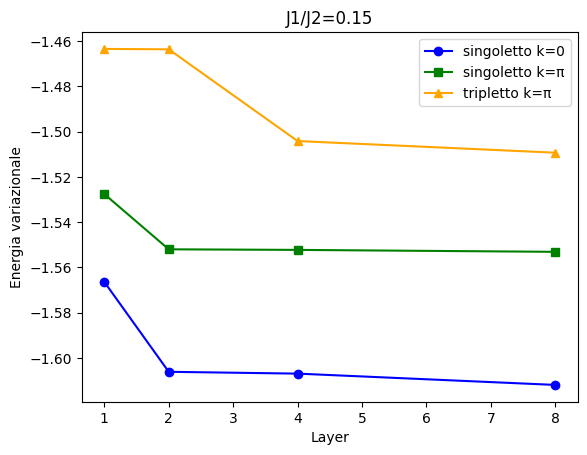

In [ ]:
plt.plot(ascisse, results[0], label="singoletto k=0", linestyle="-", marker="o", color='blue')
plt.plot(ascisse, results[1], label="singoletto k=π", linestyle="-", marker="s", color='green')
plt.plot(ascisse, results[2], label="tripletto k=π", linestyle="-", marker="^", color='orange')
plt.title("J2/J1=0.15")
plt.xlabel("Layer")
plt.ylabel("Energia variazionale")
plt.legend()
plt.savefig(fname='grafico15.jpg')
plt.show()

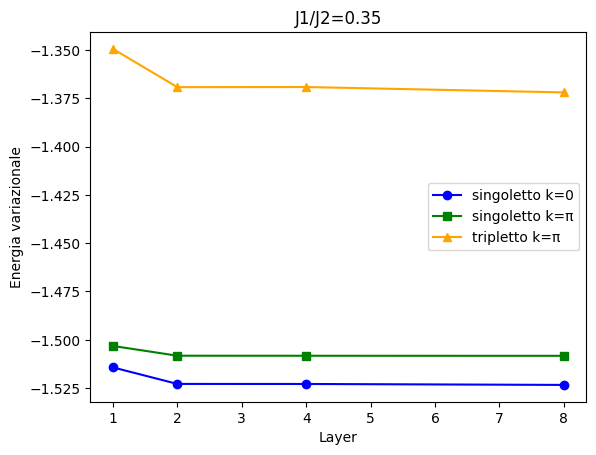

In [ ]:
plt.plot(ascisse, results[3], label="singoletto k=0", linestyle="-", marker="o", color='blue')
plt.plot(ascisse, results[4], label="singoletto k=π", linestyle="-", marker="s", color='green')
plt.plot(ascisse, results[5], label="tripletto k=π", linestyle="-", marker="^", color='orange')
plt.title("J2/J1=0.35")
plt.xlabel("Layer")
plt.ylabel("Energia variazionale")
plt.legend()
plt.savefig(fname='grafico35.jpg')
plt.show()